<a href="https://colab.research.google.com/github/gKorada/MLPractice/blob/main/FFNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt


Process Images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images_path = '/content/drive/MyDrive/t10k-images-idx3-ubyte.gz'
labels_path = '/content/drive/MyDrive/t10k-labels-idx1-ubyte.gz'

f = gzip.open(images_path, 'rb')

header_bytes = f.read(16)

magic_number, num_images, num_rows, num_cols = struct.unpack('>IIII', header_bytes)

print('Magic Number:', magic_number)
print('Number of Images:', num_images)
print('Number of Rows:', num_rows)
print('Number of Columns:', num_cols)

buf = f.read(num_images * num_rows * num_cols)
images = np.frombuffer(buf, dtype=np.uint8).astype(np.float32).reshape(num_images,1, num_rows, num_cols)

Magic Number: 2051
Number of Images: 10000
Number of Rows: 28
Number of Columns: 28


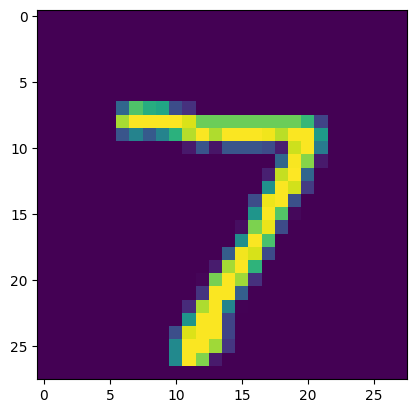

In [ ]:
image = np.asarray(images[0]).squeeze()
plt.imshow(image)
plt.show()

Process Labels

In [ ]:
f = gzip.open(labels_path, 'rb')

header_bytes = f.read(8)

magic_number, num_labels = struct.unpack('>II', header_bytes)

buf = f.read(num_labels)
labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
print('Magic Number:', magic_number)
print('Number of Labels:', num_labels)
print('First 10 labels:', labels[:10])


Magic Number: 2049
Number of Labels: 10000
First 10 labels: [7 2 1 0 4 1 4 9 5 9]


In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

from PIL import Image

Create custom dataset for our data

In [ ]:
class MNISTDataset(Dataset):
  def __init__(self, images, labels, transform=None):
    self.images = images
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    image = Image.fromarray(self.images[idx].astype(np.uint8).squeeze())
    image = ToTensor()(image)
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)

    return image, label


In [ ]:

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

x_train_data = MNISTDataset(x_train, y_train)
x_test_data = MNISTDataset(x_test, y_test)

In [ ]:
batch_size = 8

train_loader = DataLoader(x_train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(x_test_data, batch_size=batch_size, shuffle=True)

In [ ]:
train_images, train_labels = next(iter(train_loader))
train_images.shape, train_labels.shape

(torch.Size([8, 1, 28, 28]), torch.Size([8]))

Neural Network

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
class MyNetwork(nn.Module):

  def __init__(self):
    super(MyNetwork, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits



In [ ]:
model = MyNetwork().to(device)
print(model)

MyNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
for name,param in model.named_parameters():
  print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0012,  0.0158, -0.0103,  ...,  0.0084, -0.0254,  0.0096],
        [ 0.0078, -0.0080, -0.0114,  ...,  0.0049, -0.0055, -0.0056]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([0.0267, 0.0036], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0145,  0.0395,  0.0224,  ..., -0.0316, -0.0030, -0.0403],
        [-0.0147, -0.0370,  0.0163,  ...,  0.0078,  0.0207, -0.0037]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | Size: torch.Size([512]) | Values : tensor([-0.0168, -0.0332], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.4.weight | Size: torch.Size([10, 512]) | Values : tensor([[ 0.0168,  0.0374, -0.0149,  ...,  0.0109, -0.0314, -0.0426],
        [-0.0164,  0.0010,  0.0394,  

In [ ]:
learning_rate = 1e-4

epochs = 5

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


Training and Evaluation

In [ ]:


for epoch in range(epochs):
  model.train()
  for batch, (X, y) in enumerate(train_loader):
    X, y = X.to(device), y.to(device)

    pred = model(X)
    loss = loss_fn(pred, y)

    #backwards prop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss = loss.item()
      print(f"Epoch : {epoch} | Batch : {batch} | Loss : {loss}")

  #eval
  model.eval()
  total_loss, correct = 0,0

  with torch.no_grad():
    for X, y in test_loader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      loss = loss_fn(pred, y)
      total_loss += loss.item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  total_loss /= len(test_loader)
  correct /= len(test_loader.dataset)
  print(f"Epoch : {epoch} | Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {total_loss:>8f} \n")

Epoch : 0 | Batch : 0 | Loss : 0.00431431271135807
Epoch : 0 | Batch : 100 | Loss : 0.2057623565196991
Epoch : 0 | Batch : 200 | Loss : 0.01760086975991726
Epoch : 0 | Batch : 300 | Loss : 0.12377364188432693
Epoch : 0 | Batch : 400 | Loss : 0.03513731062412262
Epoch : 0 | Batch : 500 | Loss : 0.014068175107240677
Epoch : 0 | Batch : 600 | Loss : 0.15004223585128784
Epoch : 0 | Batch : 700 | Loss : 0.1300620585680008
Epoch : 0 | Batch : 800 | Loss : 0.029588453471660614
Epoch : 0 | Batch : 900 | Loss : 0.006485359743237495
Epoch : 0 | Test Error: 
 Accuracy: 93.9%, Avg loss: 0.199771 

Epoch : 1 | Batch : 0 | Loss : 0.016916461288928986
Epoch : 1 | Batch : 100 | Loss : 0.06814837455749512
Epoch : 1 | Batch : 200 | Loss : 0.06048255041241646
Epoch : 1 | Batch : 300 | Loss : 0.026265397667884827
Epoch : 1 | Batch : 400 | Loss : 0.022905422374606133
Epoch : 1 | Batch : 500 | Loss : 0.08361189067363739
Epoch : 1 | Batch : 600 | Loss : 0.018446573987603188
Epoch : 1 | Batch : 700 | Loss : 0

Save model

In [ ]:
torch.save(model, '/content/drive/MyDrive/model1.cpt')
print("saved")

saved
